# Regularizers as memory

_W. Evan Durno, 2022_

The greatest challenge in modern AI research is the limiting returns in computational work. 
While the greatest advances can only be afforded by large technology companies, even they 
cannot afford to push results further. A clear plateau has developed. 
Insufficient computational efficiency motivates a return to theory, begs a question: 
_where is waste most significant?_ 

The advent of catestrophic forgetting shows raw, non-compressed information must be continually re-applied 
if it is not to be forgotten. If important information could be preserved--even partially--we would expect 
more efficient computation. In short, _this work targets the realization of memory_.

Regularized likelihood equations have a Lagrangian form, so implicitly describe geometric constraints on estimates.
For example, here's an estimate constrained to an L2-sphere in $\Theta$-space.

$$ \hat \theta_{L_2} = \text{arg max}_{\theta \in \Theta} n^{-1} \sum_{i=1}^n \log f_X(X_i;\theta) - \lambda \| \theta \|_2^2 $$

In this work, we'll generalize the regularizer $\| \cdot \|_2^2$ to support alternative geometries, 
in attempting to construct numerically convenient memory approximations. 
Particulary, we'll seek to approximate the following equation.
Note that it introduces quadratic geometric constraints on the estimate. 

$$ \hat \theta = \text{arg max}_{\theta \in \Theta} n^{-1} \sum_{i=1}^n \log f_X(X_i;\theta) - \frac{\lambda}{2} (\theta - \theta_0)^T \mathcal{I}_{\theta_0} (\theta - \theta_0) $$

I believe the success of deep learning has so far been a product of raw computational power and mathematical rigour. 
Since computational power is no-longer growing fast enough, it's time to improve the mathematical foundations of deep learning.
My approach will derive theoretical correctness from what I call _almost-stationary processess_.

## RL-reweighted (RLR) estimates 

This first estimate is designed to improve efficiency of sampling in reinforcement learning (RL) by 
up-weighting more-important observations. We'll use this estimate:

$$ \hat \theta_{RLR} = \hat \theta_{n_1+n_2} = \text{arg max}_\theta \left( \sum_{i=1}^{n_1+n_2} \| \hat r_i \|_2^{2b} \right)^{-1} \left( \sum_{i=n_1+1}^{n_1+n_2} \| \hat r_i \|_2^{2b} \log f_X(X_i; \theta) - \sum_{i=1}^{n_1} \frac{\lambda}{2} (\theta - \hat \theta_{n_1+n_2-1})^T H_i (\theta - \hat \theta_{n_1+n_2-1}) \right) $$

where 
- $n_1$ is the number of priviously observed sameples, 
- $n_2$ is the number of newly observed samples, 
- $\hat r_i$ is the estimated reward for observation $i$, 
- $b > 0$ is a bias term,  
- $H_i = \| \hat r_i \|^{2b}_2 \left( \nabla_\theta \log f_X(X_j; \theta)|_{\theta = \hat \theta_{j-1}} \right) \left( \nabla_\theta \log f_X(X_j; \theta)|_{\theta = \hat \theta_{j-1}} \right)^T$ is a Hessian approximation, and
- $\hat \theta_0$ is an initial estimate guess, commonly required in optimization routines. 

Define $ M:= \sum_{i=1}^{n_1}(\theta - \theta_{n_1+n_2-1})^TH_i(\theta - \theta_{n_1+n_2-1})$, which we'll refer to as the "memory term". 
The key heuristic is that $M$, a quadratic regularizer, approximates large-sample likelihoods under maximization. 
This insight can be seen through a Taylor approximation near true $\theta$, designated $\theta_T$.

$\hat \theta_{MLE} = \text{arg max}_\theta n^{-1} \sum_{i=1}^n \log f_X(X_i;\theta) $

$ \approx \text{arg max}_\theta n^{-1}\sum_i \log f_X(X_i; \theta_T) + n^{-1}\sum_i (\theta - \theta_T)^T \nabla_\theta \log f_X(X_i; \theta_T) + n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

$ \approx \text{arg max}_\theta n^{-1}\sum_i \log f_X(X_i; \theta_T) + 0 + n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

$ \approx \text{arg max}_\theta n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

This work basically tests the quality of our $M \approx \sum_i (\theta - \theta_T)^T (\nabla_\theta)^2 \log f_X(X_i; \theta_T)(\theta - \theta_T) $ heuristic.
If true, then we should see that the quadratic regularizer, $M$, affects memory through geometric constraints on the estimator.

Later, we'll experiment with recency bias and rank reductions for $M$.

Notice that $\hat \theta_{RLR}$ is asymptotically equivalent to a redistributed sampling, 
with more observations when they are more important. 
Hence, the essence of this computational efficiency strategy is to 
- add frequency bias to important observations, 
- and preserve their information via geometric estimator constraints.

## $M$ and almost-stationary processes

$M$ is an asymptotic result, so only applies when observations are sufficiently many and produced by a stationary or i.i.d process.
While most applied asymptotic theory assumes $\theta_T$ is static, it could also be possible to work with a $\theta_{T_n}$ on a continuous path in $\Theta$ over $n$.
Let us define an _almost-stationary process_ $X_n$ as satisfying the following.

$$ \forall \tau \in \mathbb{R}, \left(t_1, t_2, \ldots, t_m\right) \in \mathbb{R}_{\geq 0}^m, \mathbb{P}\left[ X_{t_{1+\tau}}, X_{t_{2+\tau}}, \ldots, X_{t_{m+\tau}} ; \theta_{t_1+\tau} \right] \text{ is continuous in } \tau$$

The question of whether $\theta_{T_n}$ moves "too quickly" is dependent on an given process. 
If, for $n$ large, $M$ still approximates $\sum_i (\theta - \theta_{T_n})^T (\nabla_\theta^2 \log f_X(X_i; \theta_{T_n}))(\theta - \theta_{T_n})$, 
then we'll say $\theta_{T_n}$ is "sufficiently slow". Here are some examples relating to **transfer learning**.
- If we withheld digits 1 & 2 from MNIST for the first 10000 observations, then started including them afterward, 
we should expect $\theta_{T_n}$ to move too quickly. 
- As reinforcement learning (RL) agent explores its world, it's sampling process indeed deforms, albeit slowly. 
This context should have good opportunities for sufficiently slow changes in $\theta_{T_n}$. 
So, our experiments will focus on RL applications.

Developing transfer learning mechanisms for RL is particularly valuable, 
since it is frequently imagined to be a path to artificial general intelligence (AGI).

Side node: almost-stationary process theory clearly needs development. 
My experience has taught me to test the value of theoretical hypotheses before developing them, 
since theoretical development is far more expensive than computational experimentation.
I am confident in this hypothesis, because my previous theoretical developments are very similar. 
Any new proofs would not be very novel, and would be mere adaptations of prior work. 

## Experiment 1: Cartpole

We start with a _very_ simple example, proving-out concepts. 
The goal is to prove that $M$ provides a memory effect by detecting metric lift when the observation cache is cleared. 

For our first experiment, we run Cartpole for 1000 iterations, apply an experimental condition or 
control effect to the agent, then run for another 1000 iterations. Per condition, we track the cumulative score as our metric, 
resetting to zero upon game completions. The agent performs one optimizer update per iteration. 
Naturally, the metric has high-variance, so we use Databricks to execute 1000 experiments in parallel per condition, and average the metric.
Thus, the below-plotted metrics represent average score over time. 
The same agent is used up to the 1000 iterations before copying and applying effects, hence equivalent scores for the first half. 

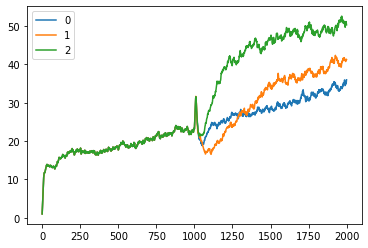

In [2]:
## DATA GENERATED WITH THIS CODE ON DATABRICKS: https://github.com/wdurno/notebooks/commit/42f49a4a22752f750dc645c3ac84de234e0a41d3
import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-4.28.22.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 

plt.plot(scores0, label='0') ## control 0: use no memory, discard no observations 
plt.plot(scores1, label='1') ## control 1: use no memory, discard observations at iteration 1000 
plt.plot(scores2, label='2') ## experimental condition: use memory, discard observations at iteration 1000 
plt.legend() 
plt.show() 

### Interpretation 

It is clear that the regularized memory term $M$ has provided significant metric lift. 
This in itself is obviously valuable and certainly still allows $M$ to apply a memory effect. 
However, a variety of concerns still stand.
- 1. Is this just the benefit of using a regularizer? Probably not, since we only have `[32, 32]` hidden nodes, but this must be tested.
- 2. 1000 iterations is very few. Does this have any benefit late-game? How about in more-complex games?
- 3. If we are observing memory, it is in the Fisher Information matrix, an asymptotic result representing no single observations but infinitely many. 
In what nuanced ways is this memory constrained? Is it similar to long-term memory, but not short-term? 
- 4. Exact Information matrices cannot be stored for large models due to their large $O(p^2)$ memory requirement. 
Can this method be made computationally feasible?

Prior to running this experiment, I expected the control to produce the highest scores at iteration 2000. 
I expect its lower performance is due to its observation cache being loaded with data generated by random play. 
It does make sense that it should out-perform condition 1 initially, but the poorer long-run performance was surprising.
This result illustrates the limited value of infinite memory. 

Immediately after iteration 1000, scores spike and fall together. 
I interpret this as a non-informative correlation, resulting from all agents starting new games simultaneously. 

## Experiment 2: Computational feasibility via low-rank approximations

The first concern we contend with is 4, computational feasibility. 
Usefully large models cannot use complete Fisher Information matrices, so we must experiment with approximations. 

We start by reducing the rank of the Information matrix by diagonalizing and only keeping the largest eigenvalues. 
Eigenvector and eigenvalue computation is still expensive, so this method will only prove feasibility without demonstrating a computational benefit. 

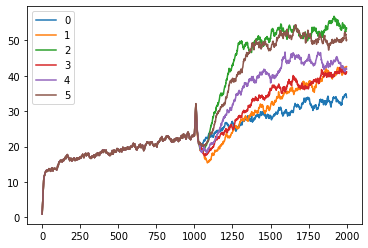

In [4]:
## DATA GENERATED WITH THIS CODE ON DATABRICKS: https://github.com/wdurno/notebooks/commit/d4db1a7558317d27de1f4668a741109760badb88 

df = pd.read_csv('data/df-4.30.22-2.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 
scores3 = df.scores3.tolist() 
scores4 = df.scores4.tolist() 
scores5 = df.scores5.tolist() 

plt.plot(scores0, label='0') ## control 0: use no memory, discard no observations 
plt.plot(scores1, label='1') ## control 1: use no memory, discard observations at iteration 1000 
plt.plot(scores2, label='2') ## experimental condition 1: use memory, discard observations at iteration 1000, use complete Hessian 
plt.plot(scores3, label='3') ## experimental condition 2: use memory, discard observations at iteration 1000, use 1 eigenvector to approximate the Hessian 
plt.plot(scores4, label='4') ## experimental condition 2: use memory, discard observations at iteration 1000, use 2 eigenvectors to approximate the Hessian 
plt.plot(scores5, label='5') ## experimental condition 2: use memory, discard observations at iteration 1000, use 10 eigenvectors to approximate the Hessian
plt.legend()
plt.show()

### Interpretation 

We observe that it takes about 10 eigenvectors before lift is comparable to full-rank Fisher Information matrices. 
I'm not surprised to see that higher-ranked approximations provide better lift.
With evidence supporting the low-rank approach, it is time to test the effectiveness of a low-rank matrix approximation routine.

## Discussion

This work is far from complete. 
However, we do have some observations.
- The technique has produced metric lift, which is valuable regardless of conclusions. However, it could just be a regularizing effect. 
- If memory has been observed, its interpretation is nuanced and likely counter-intuitive due to its theoretical origins being asymptotic in nature. 
- With lift observed, I'm now searching for computational feasibility. 